In [2]:
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind

import matplotlib.pyplot as plt

In [3]:
from selenium.common.exceptions import ElementClickInterceptedException


In [4]:
import pandas as pd
from selenium import webdriver  
from selenium.webdriver.chrome.service import Service  
from selenium.webdriver.common.by import By  
from selenium.webdriver.chrome.options import Options  
from webdriver_manager.chrome import ChromeDriverManager  
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
import time  
import random  

In [5]:
# Set up ChromeDriver using webdriver_manager
chrome_options = Options()  # Initialize Chrome options (optional)
service = Service(ChromeDriverManager().install())  # Install and set up ChromeDriver as a service

# Create a ChromeDriver instance
browser = webdriver.Chrome(service=service, options=chrome_options)

# Open the website
url = 'https://www.nhl.com/stats/teams?aggregate=0&reportType=season&seasonFrom=20112012&seasonTo=20232024&gameType=2&sort=a_seasonId&page=0&pageSize=50'
browser.get(url)

# Maximize the browser window for better visibility
browser.maximize_window()

# Wait a random time between 3-7 seconds before starting
time.sleep(random.uniform(3, 7))

In [6]:
team= []
season= []
games_played= []
wins= []
losses= []
overtime_losses= []
points= []
point_perc= []
gf= []
ga= []

In [7]:

def scrape_page():
    # Find rows
    rows = browser.find_elements(By.XPATH, '//tbody[@class="rt-tbody"]/tr')
    for i, row in enumerate(rows):
        try:
            # Locate all columns in the current row
            cols = row.find_elements(By.XPATH, './/td')
            team.append(cols[1].text)  # Second column: Team
            season.append(cols[2].text)  # Third column: Season
            games_played.append(cols[3].text)       # Fourth column: GP
            wins.append(cols[4].text)               # Fifth column: Wins
            losses.append(cols[5].text)             # Sixth column: Losses
            overtime_losses.append(cols[7].text)    # Eighth column: OT Losses
            points.append(cols[8].text)             # Ninth column: Points
            point_perc.append(cols[9].text)         # Tenth column: Point Percentage
            gf.append(cols[13].text)                # Fourteenth column: Goals For
            ga.append(cols[14].text)                # Fifteenth column: Goals Against
        except IndexError:
            print(f"Row {i} does not have enough columns. Skipping.")


In [8]:


while True:
    scrape_page()  # Scrape the current page
    try:
        # Wait for the Next button
        next_button = WebDriverWait(browser, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="season-tabpanel"]/span/nav/button[2]'))
        )
        
        # Scroll down
        browser.execute_script("arguments[0].scrollIntoView({block: 'center'});", next_button)
        
        try:
                    # Retry clicking
                    next_button.click()
        except ElementClickInterceptedException:
                    print("ElementClickInterceptedException: Retrying click after scrolling")
                    time.sleep(1)  # Wait 
                    browser.execute_script("window.scrollBy(0, 300);")  # Scroll down
                    browser.execute_script("arguments[0].click();", next_button)
                    time.sleep(random.uniform(3, 7))  # Wait for the next page to load
    except TimeoutException:
        print("Timeout waiting for Next")
        break
    except NoSuchElementException:
        print("No more pages to scrape")
        break
browser.quit()  # Close the browser after scraping
# Convert to df
data = {
    'Team': team,
    'Season': season,
    'Games Played': games_played,
    'Wins': wins,
    'Losses': losses,
    'Overtime Losses': overtime_losses,
    'Points': points,
    'Point Percentage': point_perc,
    'Goals For': gf,
    'Goals Against': ga
}
stats = pd.DataFrame(data)  


# Convert specific columns to float64
columns_to_convert = [
    'Games Played', 'Wins', 'Losses', 'Overtime Losses',
    'Points', 'Point Percentage', 'Goals For', 'Goals Against'
]
for column in columns_to_convert:
    stats[column] = stats[column].astype('float64')

stats['Season'] = stats['Season'].astype(str)


ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
ElementClickInterceptedException: Retrying click after scrolling
Timeout waiting for Next


In [9]:
# Ensure column headers are set correctly
stats.columns = ['Team', 'Season', 'Games Played', 'Wins', 'Losses', 'Overtime Losses', 'Points', 'Point Percentage', 'Goals For', 'Goals Against']

# Display the DataFrame to verify
print(stats.head())

                  Team   Season  Games Played  Wins  Losses  Overtime Losses  \
0    New Jersey Devils  2011-12          82.0  48.0    28.0              6.0   
1   New York Islanders  2011-12          82.0  34.0    37.0             11.0   
2     New York Rangers  2011-12          82.0  51.0    24.0              7.0   
3  Philadelphia Flyers  2011-12          82.0  47.0    26.0              9.0   
4  Pittsburgh Penguins  2011-12          82.0  51.0    25.0              6.0   

   Points  Point Percentage  Goals For  Goals Against  
0   102.0             0.622      216.0          205.0  
1    79.0             0.482      196.0          251.0  
2   109.0             0.665      222.0          182.0  
3   103.0             0.628      260.0          225.0  
4   108.0             0.659      273.0          218.0  


In [10]:
stats.to_csv('nhl_stats.csv', index=False)

In [11]:
# Load the salary cap data from the CSV file
salary_cap_df = pd.read_excel(r"NHL Salary Cap.xlsx")
salary_cap_df['Season'] = salary_cap_df['Season'].astype(str)
salary_cap_df['Injured'] = salary_cap_df['Injured'].astype(float)
salary_cap_df['Long0term IR'] = salary_cap_df['Long0term IR'].astype(float)
# Display the first few rows to verify
print(salary_cap_df.head())

  Season  Team  Total Players  Average Age  Cap Space  Total Cap  \
0   2023   ANA             55         25.3   13168855   70331145   
1   2023   CHI             54         27.3   12857222   70642778   
2   2023   ARI             54         25.9   12180382   71319618   
3   2023   BUF             51         25.0   10676071   72823929   
4   2023   SJS             62         27.1    9725679   73749321   

   Long0term IR    Active     Injured  
0           0.0  62409004   2750000.0  
1           0.0  51951617   6000000.0  
2           0.0  42536666  23148206.0  
3           0.0  66673872   4285714.0  
4           0.0  48219231  13425000.0  


In [12]:
salary_cap_df.dtypes

Season            object
Team              object
Total Players      int64
Average Age      float64
Cap Space          int64
Total Cap          int64
Long0term IR     float64
Active             int64
Injured          float64
dtype: object

In [13]:
stats['Season'] = stats['Season'].str.split('-').str[0]

In [14]:
# Convert the 'Season' column to integers and drop rows with NaN values
salary_cap_df = salary_cap_df.dropna(subset=['Season'])


In [15]:
salary_cap_df['Season'] = salary_cap_df['Season'].astype(str).str.replace('.0', '', regex=False)

In [28]:
# Mapping of abbreviated team names in salary_cap_df to full team names
team_name_mapping = {
    'ANA': 'Anaheim Ducks',
    'CHI': 'Chicago Blackhawks',
    'ARI': 'Arizona Coyotes',
    'BUF': 'Buffalo Sabres',
    'SJS': 'San Jose Sharks',
    'CBJ': 'Columbus Blue Jackets',
    'CGY': 'Calgary Flames',
    'DET': 'Detroit Red Wings',
    'WAS': 'Washington Capitals',
    'SEA': 'Seattle Kraken',
    'NJD': 'New Jersey Devils',
    'NSH': 'Nashville Predators',
    'STL': 'St. Louis Blues',
    'MIN': 'Minnesota Wild',
    'NYR': 'New York Rangers',
    'MTL': 'Montréal Canadiens',
    'VGK': 'Vegas Golden Knights',
    'NYI': 'New York Islanders',
    'VAN': 'Vancouver Canucks',
    'TOR': 'Toronto Maple Leafs',
    'COL': 'Colorado Avalanche',
    'OTT': 'Ottawa Senators',
    'PIT': 'Pittsburgh Penguins',
    'TBL': 'Tampa Bay Lightning',
    'BOS': 'Boston Bruins',
    'LAK': 'Los Angeles Kings',
    'DAL': 'Dallas Stars',
    'EDM': 'Edmonton Oilers',
    'CAR': 'Carolina Hurricanes',
    'WPG': 'Winnipeg Jets',
    'FLA': 'Florida Panthers',
    'PHI': 'Philadelphia Flyers',
    'PHX': 'Arizona Coyotes',  # Phoenix Coyotes is now Arizona Coyotes
}
salary_cap_df['Team'] = salary_cap_df['Team'].replace(team_name_mapping)

In [29]:
# Strip from the Team column in salary_cap_df
salary_cap_df['Team'] = salary_cap_df['Team'].str.strip()

# Map the abbreviated team names in salary_cap_df to the full team names in stats
salary_cap_df['Team'] = salary_cap_df['Team'].replace(team_name_mapping)

In [31]:
stats.dtypes

Team                 object
Season               object
Games Played        float64
Wins                float64
Losses              float64
Overtime Losses     float64
Points              float64
Point Percentage    float64
Goals For           float64
Goals Against       float64
dtype: object

In [ ]:
merged_df = pd.merge(stats, salary_cap_df, on=['Team', 'Season'], how='inner')

print(merged_df.head())

                  Team Season  Games Played  Wins  Losses  Overtime Losses  \
0    New Jersey Devils   2011          82.0  48.0    28.0              6.0   
1   New York Islanders   2011          82.0  34.0    37.0             11.0   
2     New York Rangers   2011          82.0  51.0    24.0              7.0   
3  Philadelphia Flyers   2011          82.0  47.0    26.0              9.0   
4  Pittsburgh Penguins   2011          82.0  51.0    25.0              6.0   

   Points  Point Percentage  Goals For  Goals Against  Total Players  \
0   102.0             0.622      216.0          205.0             43   
1    79.0             0.482      196.0          251.0             40   
2   109.0             0.665      222.0          182.0             46   
3   103.0             0.628      260.0          225.0             38   
4   108.0             0.659      273.0          218.0             41   

   Average Age  Cap Space  Total Cap  Long0term IR    Active  Injured  
0         27.4    1768336 

In [35]:
merged_df.to_csv('merged_data.csv', index=False)

In [44]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X = merged_df[['Active']].values  # Active cap spending
y = merged_df['Points'].values  # Points

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared value: {r2}")

# Display the regression coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

R-squared value: 0.12421570230884593
Intercept: 37.17695023503407
Coefficient: 7.507139407777383e-07


/Users/johnreisfield/Desktop/Anaconda/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


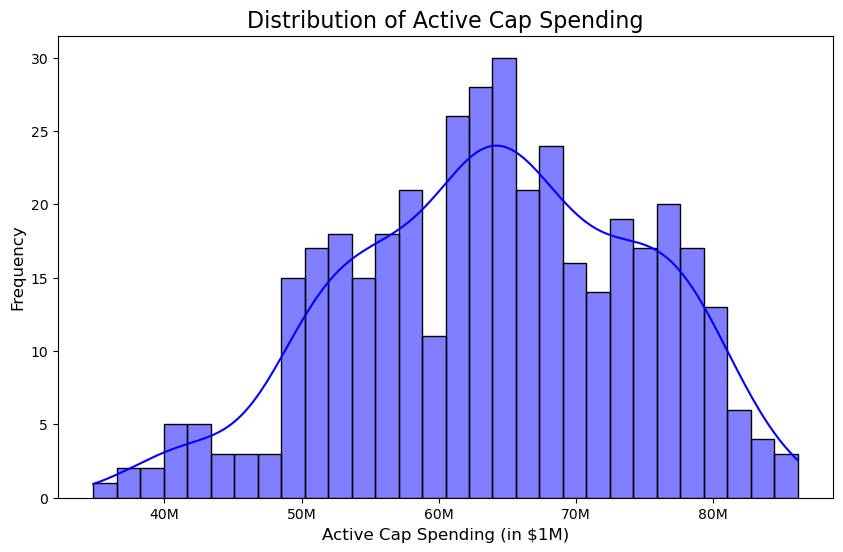

In [43]:
import matplotlib.ticker as mtick

# Univariate Analysis: Distribution of Cap Spending
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Active'] / 1e6, kde=True, bins=30, color='blue')  # Scale data to millions directly
plt.title('Distribution of Active Cap Spending', fontsize=16)
plt.xlabel('Active Cap Spending (in $1M)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Format the x-axis to show values like 40M, 50M, etc.
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}M'))

plt.show()

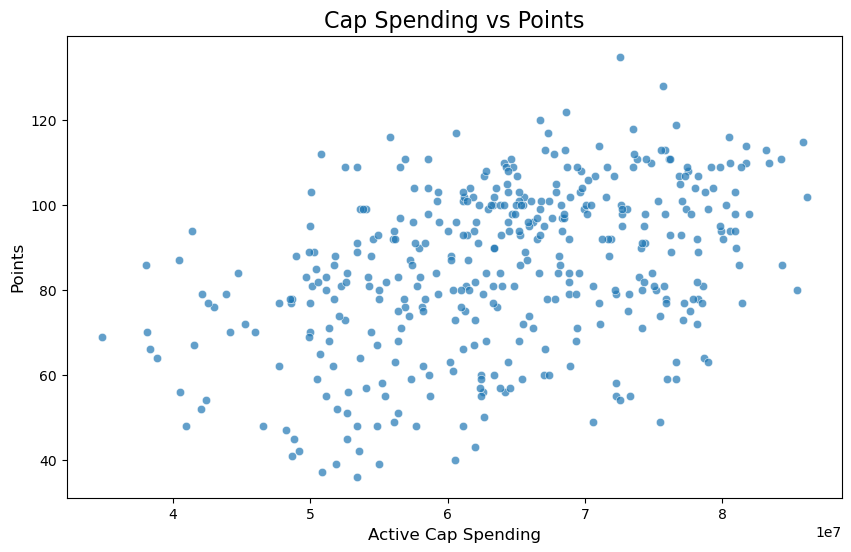

Pearson Correlation Coefficient: 0.40780077860774117
P-value: 2.4371420858141744e-17
T-statistic: 7.991201278809738
P-value: 1.48350756030923e-14


In [39]:
# Bivariate Analysis: Scatterplot of Cap Spending vs Points
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['Active'], y=merged_df['Points'], alpha=0.7)
plt.title('Cap Spending vs Points', fontsize=16)
plt.xlabel('Active Cap Spending', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.show()

# Hypothesis Test: Correlation between Cap Spending and Points
correlation, p_value = pearsonr(merged_df['Active'], merged_df['Points'])
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Comparing Points for Teams Above and Below Median Cap Spending Hypthesis Test 2
median_cap = merged_df['Active'].median()
above_median = merged_df[merged_df['Active'] > median_cap]['Points']
below_median = merged_df[merged_df['Active'] <= median_cap]['Points']

t_stat, t_p_value = ttest_ind(above_median, below_median)
print(f"T-statistic: {t_stat}")
print(f"P-value: {t_p_value}")

In [40]:
# Select features for the regression model
features = ['Active', 'Cap Space', 'Total Cap', 'Long0term IR', 'Injured', 'Average Age']
X_multi = merged_df[features].values  # Independent variables
y_multi = merged_df['Points'].values  # Dependent variable

# Split the data into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Create and train the regression model
multi_model = LinearRegression()
multi_model.fit(X_train_multi, y_train_multi)

# Make predictions
y_pred_multi = multi_model.predict(X_test_multi)

# Evaluate the model
r2_multi = r2_score(y_test_multi, y_pred_multi)
print(f"R-squared value (multi-feature): {r2_multi}")

# Display the regression coefficients
print(f"Intercept: {multi_model.intercept_}")
print(f"Coefficients: {dict(zip(features, multi_model.coef_))}")

R-squared value (multi-feature): 0.196068265219157
Intercept: 95.23088244381266
Coefficients: {'Active': 1.0174181474685266e-06, 'Cap Space': -1.2274999220827581e-06, 'Total Cap': -9.55725475369074e-07, 'Long0term IR': 1.4115608490194558e-06, 'Injured': 3.730440746293088e-07, 'Average Age': -0.0696944557862625}
